In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [4]:
!pip install catboost

     |████████████████████████████████| 64.8MB 64kB/s 


In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

In [0]:
from package import MakeFeatures, make_predict

In [0]:
train = pd.read_csv('flight_delays_train.csv')
test = pd.read_csv('flight_delays_test.csv')

In [0]:
R_STATE = 17

In [9]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [0]:
X_train, y_train = train.drop(['dep_delayed_15min'], axis=1), train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

## No Feature Transform

In [0]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, 
                                                                y_train, 
                                                                test_size=0.3, 
                                                                random_state=R_STATE)

In [12]:
X_train_part.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 98187 to 76399
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Month          70000 non-null  object
 1   DayofMonth     70000 non-null  object
 2   DayOfWeek      70000 non-null  object
 3   DepTime        70000 non-null  int64 
 4   UniqueCarrier  70000 non-null  object
 5   Origin         70000 non-null  object
 6   Dest           70000 non-null  object
 7   Distance       70000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 4.8+ MB


In [0]:
train = Pool(X_train_part, y_train_part,cat_features=[0,1,2,4,5,6])

In [14]:
cbc_model = CatBoostClassifier(random_seed=R_STATE, verbose=True)
cbc_model.fit(train)

Learning rate set to 0.063211
0:	learn: 0.6608956	total: 161ms	remaining: 2m 41s
1:	learn: 0.6323670	total: 235ms	remaining: 1m 57s
2:	learn: 0.6097381	total: 323ms	remaining: 1m 47s
3:	learn: 0.5893880	total: 387ms	remaining: 1m 36s
4:	learn: 0.5707463	total: 469ms	remaining: 1m 33s
5:	learn: 0.5543565	total: 554ms	remaining: 1m 31s
6:	learn: 0.5417254	total: 604ms	remaining: 1m 25s
7:	learn: 0.5295144	total: 716ms	remaining: 1m 28s
8:	learn: 0.5203616	total: 772ms	remaining: 1m 25s
9:	learn: 0.5104568	total: 879ms	remaining: 1m 27s
10:	learn: 0.5037401	total: 959ms	remaining: 1m 26s
11:	learn: 0.4968390	total: 1.05s	remaining: 1m 26s
12:	learn: 0.4902548	total: 1.15s	remaining: 1m 27s
13:	learn: 0.4851748	total: 1.25s	remaining: 1m 28s
14:	learn: 0.4801013	total: 1.36s	remaining: 1m 29s
15:	learn: 0.4762848	total: 1.48s	remaining: 1m 31s
16:	learn: 0.4726597	total: 1.61s	remaining: 1m 33s
17:	learn: 0.4695807	total: 1.68s	remaining: 1m 31s
18:	learn: 0.4667793	total: 1.8s	remaining: 

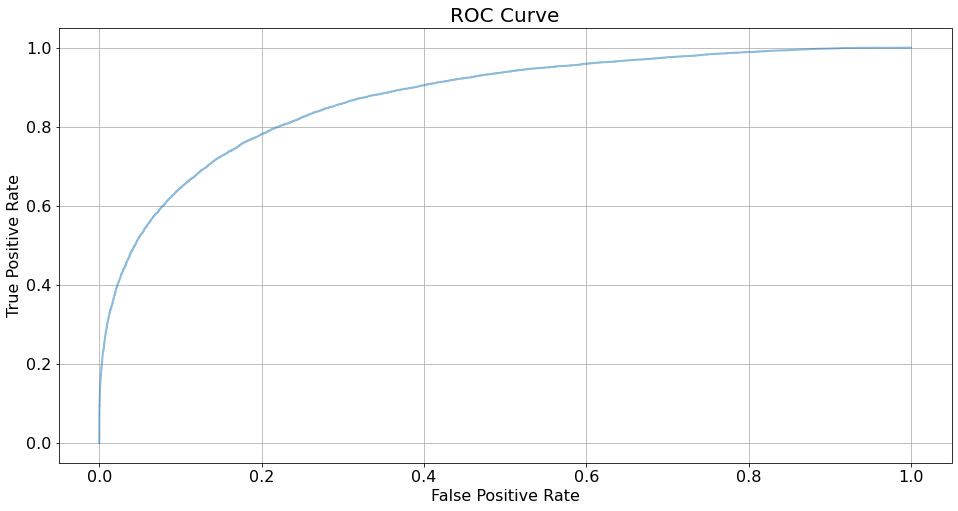

(array([0.        , 0.        , 0.        , ..., 0.99996468, 0.99998234,
        1.        ]),
 array([0.00000000e+00, 7.47440018e-05, 1.49488004e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.        , 0.99691201, 0.99654121, ..., 0.00316319, 0.00259472,
        0.        ]))

In [15]:
from catboost.utils import get_roc_curve

get_roc_curve(cbc_model, 
              train,
              thread_count=-1,
              plot=True)

In [16]:
pred = cbc_model.predict_proba(X_valid)

roc_auc_score(y_valid, pred[:,1])

0.7580222479290705

In [0]:
test_pool = Pool(test, cat_features=[0,1,2,4,5,6])
predict_kaggle = cbc_model.predict_proba(test_pool)[:, 1]

In [0]:
make_predict(predict_kaggle, 'cb_no_feature_transform')

## Feature Transform

In [0]:
mf = MakeFeatures(is_weekend=1, 
                  seasons=1, 
                  day_of_month=1, 
                  dep_capital=1, 
                  arr_capital=1, 
                  route=0, 
                  log_dist=1, 
                  uc=1, 
                  time = 1,
                  new_dep_time = 1,
                  hour_imp = 1)
mf.fit(X_train)

X_train_new = mf.fit_transform(X_train)
X_train_new.head()

Success
Seasons complete!
Success
IsWeekend complete!
Success
TimeOfDay complete!
Success
Day complete!
Success
DepFromCap complete!
Success
ArrivInCap complete!
Success
LogDist complete!
Success
UniqueCarrier dummies complete!
Hour Minute feature complete!
Hour_sq-s feature complete!


,Seasons_cos,Seasons_sin,IsWeekend,Day,DepFromCap,ArrForCap,LogDist,Hour,Minute,Hour_sq,Hour_sq2,AA,AQ,AS,B6,CO,DH,DL,EV,F9,FL,HA,HP,MQ,NW,OH,OO,TZ,UA,US,WN,XE,YV,day,evening,morning,night
0,-5.000000e-01,-0.866025,1,21,0,0,6.595781,19,34,361,130321,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-5.000000e-01,0.866025,0,20,0,0,6.726233,15,48,225,50625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,-1.836970e-16,-1.000000,0,2,0,0,6.030685,14,22,196,38416,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,8.660254e-01,-0.500000,1,25,0,0,6.770789,10,15,100,10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,5.000000e-01,-0.866025,1,7,0,0,6.047372,18,28,324,104976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [0]:
X = pd.concat([X_train_new, X_train.Dest, X_train.Origin], axis=1, sort=False)

In [0]:
X['UQ_DEST']=X_train.UniqueCarrier+'_'+X_train.Dest
X['UQ_ORIG']=X_train.UniqueCarrier+'_'+X_train.Origin

In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 41 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Seasons_cos  100000 non-null  float64
 1   Seasons_sin  100000 non-null  float64
 2   IsWeekend    100000 non-null  int64  
 3   Day          100000 non-null  object 
 4   DepFromCap   100000 non-null  int64  
 5   ArrForCap    100000 non-null  int64  
 6   LogDist      100000 non-null  float64
 7   Hour         100000 non-null  int64  
 8   Minute       100000 non-null  int64  
 9   Hour_sq      100000 non-null  int64  
 10  Hour_sq2     100000 non-null  int64  
 11  AA           100000 non-null  uint8  
 12  AQ           100000 non-null  uint8  
 13  AS           100000 non-null  uint8  
 14  B6           100000 non-null  uint8  
 15  CO           100000 non-null  uint8  
 16  DH           100000 non-null  uint8  
 17  DL           100000 non-null  uint8  
 18  EV           100000 non-n

In [0]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X, 
                                                                y_train, 
                                                                test_size=0.3, 
                                                                random_state=R_STATE)

In [0]:
train = Pool(X_train_part, y_train_part,cat_features=[37,38,39,40])

In [0]:
cbc_model = CatBoostClassifier(random_seed=R_STATE, verbose=True)
cbc_model.fit(train)

Learning rate set to 0.063211
0:	learn: 0.6580306	total: 168ms	remaining: 2m 47s
1:	learn: 0.6292706	total: 289ms	remaining: 2m 24s
2:	learn: 0.6054008	total: 390ms	remaining: 2m 9s
3:	learn: 0.5829387	total: 502ms	remaining: 2m 5s
4:	learn: 0.5647100	total: 594ms	remaining: 1m 58s
5:	learn: 0.5483975	total: 700ms	remaining: 1m 55s
6:	learn: 0.5351771	total: 805ms	remaining: 1m 54s
7:	learn: 0.5238845	total: 912ms	remaining: 1m 53s
8:	learn: 0.5143494	total: 1.02s	remaining: 1m 52s
9:	learn: 0.5064963	total: 1.1s	remaining: 1m 48s
10:	learn: 0.4984706	total: 1.19s	remaining: 1m 47s
11:	learn: 0.4920452	total: 1.29s	remaining: 1m 46s
12:	learn: 0.4863368	total: 1.38s	remaining: 1m 45s
13:	learn: 0.4819272	total: 1.5s	remaining: 1m 45s
14:	learn: 0.4772623	total: 1.6s	remaining: 1m 45s
15:	learn: 0.4735550	total: 1.72s	remaining: 1m 45s
16:	learn: 0.4697902	total: 1.82s	remaining: 1m 45s
17:	learn: 0.4668537	total: 1.92s	remaining: 1m 44s
18:	learn: 0.4639244	total: 2.02s	remaining: 1m 4

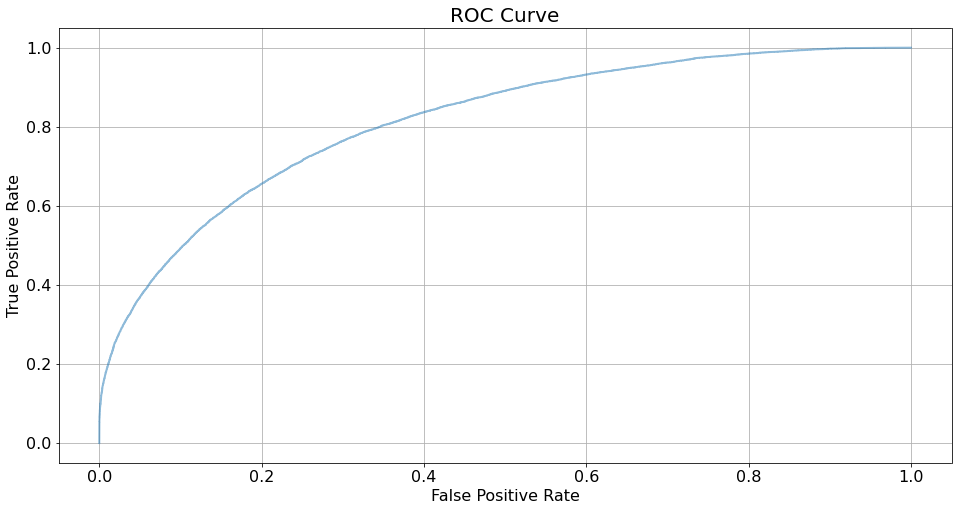

(array([0.        , 0.        , 0.        , ..., 0.99996468, 0.99998234,
        1.        ]),
 array([0.00000000e+00, 7.47440018e-05, 1.49488004e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.        , 0.99903513, 0.99891852, ..., 0.00135326, 0.00114664,
        0.        ]))

In [0]:
from catboost.utils import get_roc_curve

get_roc_curve(cbc_model, 
              train,
              thread_count=-1,
              plot=True)

In [0]:
pred = cbc_model.predict_proba(X_valid)

roc_auc_score(y_valid, pred[:,1])

0.7470297703557163

In [0]:
model = CatBoostClassifier(iterations=2000,
                           #depth=15,
                           
                           random_seed=R_STATE,
                           #custom_metric='AUC',
                           #loss_function='Logloss',
                           verbose=True)
model.fit(train)

Learning rate set to 0.033477
0:	learn: 0.6741414	total: 126ms	remaining: 4m 11s
1:	learn: 0.6573543	total: 252ms	remaining: 4m 11s
2:	learn: 0.6424303	total: 359ms	remaining: 3m 59s
3:	learn: 0.6274606	total: 478ms	remaining: 3m 58s
4:	learn: 0.6142131	total: 584ms	remaining: 3m 53s
5:	learn: 0.6016394	total: 688ms	remaining: 3m 48s
6:	learn: 0.5904399	total: 792ms	remaining: 3m 45s
7:	learn: 0.5802969	total: 901ms	remaining: 3m 44s
8:	learn: 0.5709800	total: 1.01s	remaining: 3m 42s
9:	learn: 0.5620437	total: 1.11s	remaining: 3m 41s
10:	learn: 0.5537444	total: 1.22s	remaining: 3m 41s
11:	learn: 0.5466113	total: 1.29s	remaining: 3m 33s
12:	learn: 0.5395986	total: 1.39s	remaining: 3m 33s
13:	learn: 0.5332375	total: 1.5s	remaining: 3m 32s
14:	learn: 0.5266683	total: 1.61s	remaining: 3m 33s
15:	learn: 0.5210011	total: 1.71s	remaining: 3m 31s
16:	learn: 0.5158340	total: 1.8s	remaining: 3m 29s
17:	learn: 0.5108210	total: 1.9s	remaining: 3m 29s
18:	learn: 0.5064745	total: 2.02s	remaining: 3m

In [0]:
pred = model.predict_proba(X_valid)

roc_auc_score(y_valid, pred[:,1])

0.7481690749760033

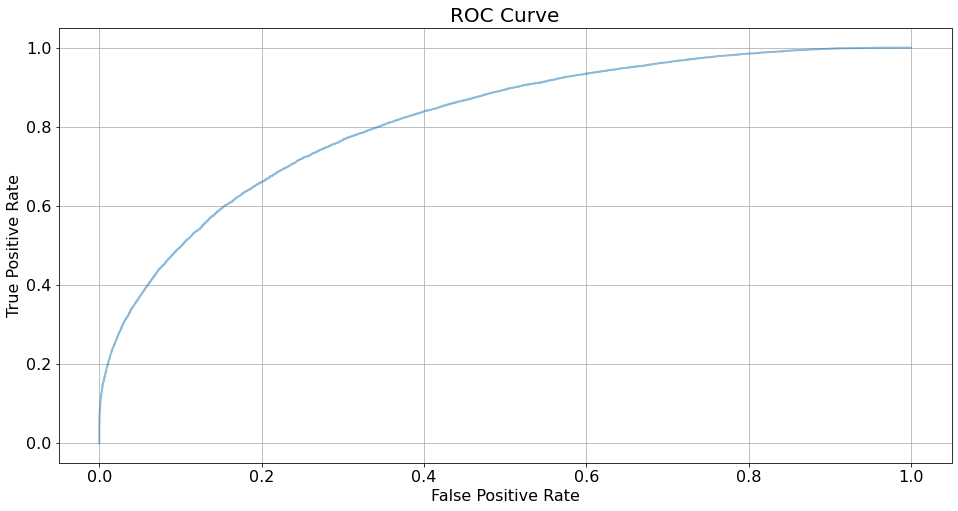

(array([0.        , 0.        , 0.        , ..., 0.99996468, 0.99998234,
        1.        ]),
 array([0.00000000e+00, 7.47440018e-05, 1.49488004e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.00000000e+00, 9.98773715e-01, 9.98679919e-01, ...,
        9.61506732e-04, 8.59748701e-04, 0.00000000e+00]))

In [0]:
get_roc_curve(model, 
              train,
              thread_count=-1,
              plot=True)

## Make prediction

In [0]:
mf_cat_test = MakeFeatures(is_weekend=1, 
                  seasons=1, 
                  day_of_month=1, 
                  dep_capital=1, 
                  arr_capital=1, 
                  route=0, 
                  log_dist=1, 
                  uc=1, 
                  time = 1,
                  new_dep_time = 1,
                  hour_imp = 1)
mf_cat_test.fit(test)
X_test=mf_cat_test.fit_transform(test)
X_test.head()

Success
Seasons complete!
Success
IsWeekend complete!
Success
TimeOfDay complete!
Success
Day complete!
Success
DepFromCap complete!
Success
ArrivInCap complete!
Success
LogDist complete!
Success
UniqueCarrier dummies complete!
Hour Minute feature complete!
Hour_sq-s feature complete!


,Seasons_cos,Seasons_sin,IsWeekend,Day,DepFromCap,ArrForCap,LogDist,Hour,Minute,Hour_sq,Hour_sq2,9E,AA,AQ,AS,B6,CO,DL,EV,F9,FL,HA,MQ,NW,OH,OO,UA,US,WN,XE,YV,day,evening,morning,night
0,-8.660254e-01,-5.000000e-01,0,25,0,0,6.393591,6,15,36,1296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,-5.000000e-01,8.660254e-01,0,17,0,0,7.118826,7,39,49,2401,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1.000000e+00,-2.449294e-16,1,2,0,0,6.357842,6,51,36,1296,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,6.123234e-17,1.000000e+00,1,25,1,0,5.932245,16,14,256,65536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,-1.000000e+00,1.224647e-16,0,6,0,0,5.552960,15,5,225,50625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [0]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Seasons_cos  100000 non-null  float64
 1   Seasons_sin  100000 non-null  float64
 2   IsWeekend    100000 non-null  int64  
 3   Day          100000 non-null  object 
 4   DepFromCap   100000 non-null  int64  
 5   ArrForCap    100000 non-null  int64  
 6   LogDist      100000 non-null  float64
 7   Hour         100000 non-null  int64  
 8   Minute       100000 non-null  int64  
 9   Hour_sq      100000 non-null  int64  
 10  Hour_sq2     100000 non-null  int64  
 11  9E           100000 non-null  uint8  
 12  AA           100000 non-null  uint8  
 13  AQ           100000 non-null  uint8  
 14  AS           100000 non-null  uint8  
 15  B6           100000 non-null  uint8  
 16  CO           100000 non-null  uint8  
 17  DL           100000 non-null  uint8  
 18  EV           100000 non-n

In [0]:
X_test_new = pd.concat([X_test, test.Dest, test.Origin], axis=1, sort=False)
X_test_new['UQ_DEST']=test.UniqueCarrier+'_'+test.Dest
X_test_new['UQ_ORIG']=test.UniqueCarrier+'_'+test.Origin

In [0]:
X_test_new['TZ']=0
X_test_new['HP']=0
X_test_new['DH']=0
X_test_new.drop(['9E'], axis=1)

X.columns, X_test_new.columns

X_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Seasons_cos  100000 non-null  float64
 1   Seasons_sin  100000 non-null  float64
 2   IsWeekend    100000 non-null  int64  
 3   Day          100000 non-null  object 
 4   DepFromCap   100000 non-null  int64  
 5   ArrForCap    100000 non-null  int64  
 6   LogDist      100000 non-null  float64
 7   Hour         100000 non-null  int64  
 8   Minute       100000 non-null  int64  
 9   Hour_sq      100000 non-null  int64  
 10  Hour_sq2     100000 non-null  int64  
 11  9E           100000 non-null  uint8  
 12  AA           100000 non-null  uint8  
 13  AQ           100000 non-null  uint8  
 14  AS           100000 non-null  uint8  
 15  B6           100000 non-null  uint8  
 16  CO           100000 non-null  uint8  
 17  DL           100000 non-null  uint8  
 18  EV           100000 non-n

In [0]:
test = Pool(X_test_new, cat_features=[38,37,36,35])
predict_kaggle = model.predict_proba(test)[:, 1]


In [0]:
make_predict(predict_kaggle,'cb')